In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pycocotools.mask import decode, encode

import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, ZeroPadding2D, UpSampling2D, Add, Reshape, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.losses import categorical_crossentropy

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.vgg19 import VGG19

import cv2

from pycocotools.cocostuffeval import *
from pycocotools.cocostuffhelper import *

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

# Data Preprocessing

In [3]:
annFile = 'annotations/stuff_val2017.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=2.38s)
creating index...
index created!


In [4]:
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

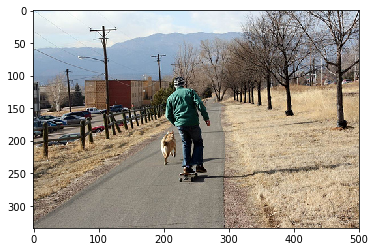

In [5]:
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.show()

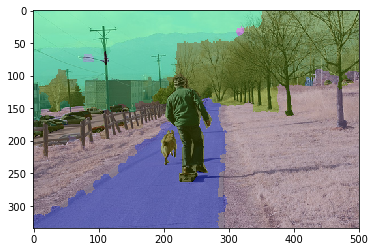

In [6]:
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [7]:
# 0, 124, 169
single_stuff = np.zeros_like(labelMap)
single_stuff[labelMap == 124] = 255
conc = np.zeros((334, 500, 3))
conc[:, :, 0] = single_stuff
conc[:, :, 1] = single_stuff
conc[:, :, 2] = single_stuff
plt.imshow(conc)

NameError: name 'labelMap' is not defined

In [3]:
def get_ground_truth(coco, imgId, num_classes=92, class_start_id=92):
    label_map = cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True)
    ground_truth = np.zeros((label_map.shape[0], label_map.shape[1], num_classes))
    
    for i in range(num_classes):
        ground_truth[:, :, i][label_map == class_start_id + i] = 1
    return ground_truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


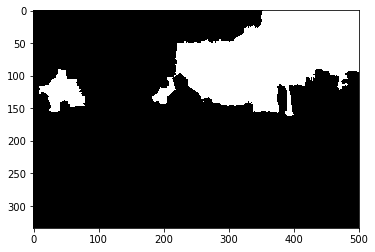

In [9]:
ground_truth = get_ground_truth(coco, 324158)
img = np.repeat(ground_truth[:, :, 77, np.newaxis], 3, axis=2)
img = img * 255
plt.imshow(img)

# Train model

In [4]:
def batch(directory, n=1):
    filenames = os.listdir(directory)
    l = len(filenames)
    
    for ndx in range(0, l, n):
        imgs = []
        batch_files = filenames[ndx:min(ndx + n, l)]
        for filename in batch_files:
            imgs.append(io.imread(os.path.join(directory, filename)))
            
        yield imgs

In [6]:
def batch(coco, input_shape, n=32):
#     if mode == 'train':
#         annFile = 'annotations/stuff_train2017.json'
#     elif mode == 'val':
#         annFile = 'annotations/stuff_val2017.json'
#     coco = COCO(annFile)
    imgIds = coco.getImgIds()
    
    l = len(imgIds)
    
    for ndx in range(0, l, n):
        batch_ids = imgIds[ndx:min(ndx + n, l)]
        imgs_dict = coco.loadImgs(batch_ids)
        
        imgs = []
        y = []
        for img in imgs_dict:
            image = io.imread(img['coco_url'])            
            reshaped = np.zeros((input_shape[0], input_shape[1], 3))
            
            cropped_h = min(image.shape[0], input_shape[0])
            cropped_w = min(image.shape[1], input_shape[1])
            reshaped[:cropped_h, :cropped_w] = image[:cropped_h, :cropped_w]
            imgs.append(reshaped.tolist())
        
        for imgId in batch_ids:
            gt = get_ground_truth(coco, imgId, num_classes=92, class_start_id=92)
            reshaped_gt = np.zeros((input_shape[0], input_shape[1], gt.shape[2]))
            reshaped_gt[:cropped_h, :cropped_w] = gt[:cropped_h, :cropped_w]
            
            y.append(reshaped_gt.tolist())
        yield np.array(imgs), np.array(y) 

In [ ]:
train_gen = batch('val')
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0])
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()

In [16]:
def gen_model():
    # input shape: (428, 640, 92)
    model = VGG19(include_top=False, input_shape=(428, 640, 3))    
    for layer in model.layers:
        layer.trainable = False
        
    skip_connection1 = model.layers[-2].output
    
    out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)  
    out = Add()([skip_connection1, out])
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    
    skip_connection2 = model.layers[5].output
    out = Add()([skip_connection2, out])
    out = BatchNormalization()(out)
       
    out = Conv2DTranspose(92, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    seg_model = Model(inputs=model.inputs, outputs=[out])   
    
    print(seg_model.summary())
    return seg_model
    
gen_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 428, 640, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 428, 640, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 428, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 214, 320, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [12]:
def gen_model():
    # output shape: (334, 500, 92)
#     model = VGG19(include_top=False, input_shape=(334, 500, 3))   
    model = VGG19(include_top=False, input_shape=(None, None, 3))    
    for layer in model.layers:
        layer.trainable = False
    
    out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)    
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((0,1))(out)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,1))(out)
    
    skip_connection = Conv2D(128, (3, 3), activation='relu', padding='same')(model.layers[0].output)    
   
    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((1,0))(out)
    
    out = Add()([skip_connection, out])
    out = BatchNormalization()(out)
    
    out = Conv2D(92, (3, 3), activation='relu', padding='same')(out)
    
    seg_model = Model(inputs=model.inputs, outputs=[out])    
    return seg_model
    
gen_model()

In [ ]:
y = np.array([get_ground_truth(coco, 324158, num_classes=92, class_start_id=92)])

In [15]:
def pixelwise_crossentropy(y_true, y_pred):
    reshaped_output = Reshape((334*500, 92))(y_pred)
    new_output = Activation('softmax')(reshaped_output)
    return categorical_crossentropy(Reshape((334*500, 92))(y_true), new_output)

In [29]:
# TODO: set steps_per_epoch, validation_steps
# def train_model(X, y):
def train_model():  
    model = gen_model()
#     model.compile('adam', 'mse', ['mae'])
    model.compile(loss=pixelwise_crossentropy, optimizer='adam')
    
    model_path = './model.h5'
    callbacks = [
    EarlyStopping(
        monitor='loss', 
        patience=10,
        mode='min',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='loss', 
        save_best_only=True, 
        mode='min',
        verbose=0)
    ]
#     history = model.fit(X, y, epochs=2, batch_size=32, validation_split=0.0, shuffle=True, callbacks=callbacks)
    
    train_file = 'annotations/stuff_val2017.json'
    coco_train = COCO(train_file)
    
    val_file = 'annotations/stuff_val2017.json'
    coco_val = COCO(val_file)

    training_generator = batch(coco_train, 1)
    validation_generator = batch(coco_val, 1)
    history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=2,
                    use_multiprocessing=False,
                    workers=1, 
                    shuffle=True,
                    steps_per_epoch=10,
                    validation_steps=10,
                    callbacks=callbacks)
    return model, history

In [ ]:
train_model()

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
loading annotations into memory...
Done (t=193.50s)
creating index...
index created!
Epoch 1/2


In [ ]:
train_model(np.array([I]), y)

# Evaluation

In [ ]:
def convert_pred_to_label_map(pred, class_start_id=92):
    return class_start_id + np.argmax(pred, axis=2)

In [ ]:
def evaluate(cocoGt):
    img = coco.loadImgs([324158])[0]
    I = io.imread(img['coco_url'])
    
    model = gen_model()    
    y = model.predict(np.array([I]))
    labelMap = convert_pred_to_label_map(y[0])
    
    anns = segmentationToCocoResult(labelMap, 324158, stuffStartId=92)   
    cocoRes = coco.loadRes(anns)
    coco_eval = COCOStuffeval(cocoGt, cocoRes)
    coco_eval.params.imgIds = [324158]
    coco_eval.evaluate()
    coco_eval.summarize()

In [ ]:
evaluate(coco)